# AutoCorrect Finetuning and Evaluation

The aim of this Jupyter Notebook is to dive into the process of finetuning a T5 model for the Spelling Correction Task on a custom dataset. 

The notebook consists of the following:

1. Preprocessing Input
2. Finetuning the T5 model
3. Evaluating Model

In [13]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split

We're using the dataset provided by "Correcting the Autocorrect: Context-Aware Typographical Error Correction via Training Data Augmentation - Kshitij Shah, Gerard de Melo" (https://arxiv.org/abs/2005.01158)

In [14]:
train_data = pd.read_csv("/kaggle/input/spellingamazoncsv/amazon/medium/train.csv")

In [3]:
print(train_data.head())

                                          Clean_Text  Upper_Count  Char_Count  \
0  ... you can absolutely forget about these. Con...           14         460   
1  It has been over three weeks and I still have ...            3         116   
2  Maybe it's all in my head, but these are the b...           10         412   
3  I was really leery of spending $45 on dog food...            9         553   
4  My mini schnauzer is about 9 to 10 months now ...            9         542   

  OOV_Words  OOV_Words_Count  Word_Count  Upper_Case_Ratio  \
0        []                0          69          0.030435   
1        []                0          22          0.025862   
2        []                0          77          0.024272   
3        []                0         115          0.016275   
4        []                0         107          0.016605   

                                      Corrupted_Text  Word_Count_Corrupt  \
0  ... you can absolutely foret abot these. Confi...            

In [9]:
!pip install evaluate
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 51.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: click
    Found existing installation: click 8.1.7
    Uninstalling click-8.1.7:
      Successfully uninstalled click-8.1.7


## Preprocessing Dataset

We'll tokenize each rows' corrupted and clean text for quick parallel processing when finetuning and evaluating the model.

In [35]:
from datasets import Dataset
import evaluate
import torch
import gc

tokenizer = T5Tokenizer.from_pretrained("t5-base")

# Define maximum lengths
MAX_INPUT_LENGTH = 512
MAX_TARGET_LENGTH = 512

def preprocess_function(examples):
    inputs = ["Autocorrect: " + text for text in examples["Corrupted_Text"]]
    targets = examples["Clean_Text"]

    model_inputs = tokenizer(
        inputs, 
        max_length=MAX_INPUT_LENGTH, 
        truncation=True, 
        return_tensors = "pt",
        padding="max_length"
    )

    labels = tokenizer(
        targets, 
        max_length=MAX_TARGET_LENGTH, 
        return_tensors = "pt",
        truncation=True, 
        padding="max_length"
    )

    # Convert labels into a format suitable for training (replace pad_token_id with -100)
    labels["input_ids"] = [
        [(id if id != tokenizer.pad_token_id else -100) for id in label] for label in labels["input_ids"]
    ]
    
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs


In [5]:
low_train = Dataset.from_pandas(pd.read_csv('/kaggle/input/spellingamazoncsv/amazon/low/train.csv').head(25000))
medium_train = Dataset.from_pandas(pd.read_csv('/kaggle/input/spellingamazoncsv/amazon/medium/train.csv').head(25000))
hard_train = Dataset.from_pandas(pd.read_csv('/kaggle/input/spellingamazoncsv/amazon/high/train.csv').head(25000))

low_train.set_format(type="torch") # .map() uses some Arrow caching which doesn't really understand tensors
medium_train.set_format(type="torch") # So we need to set_format as torch for the output from .map() to be tensors
hard_train.set_format(type="torch")

# We'll be using the earlier defined preprocess function
# EASY
print("Tokenizing easy dataset...")
tokenized_easy = low_train.map(
    preprocess_function,
    batched=True,
    batch_size=256,  # Larger batch size for tokenization
    num_proc=2,  # Reduced from 4 to avoid memory issues
    remove_columns=low_train.column_names,
    desc="Tokenizing training dataset",
)

# MEDIUM
print("Tokenizing medium dataset...")
tokenized_medium = medium_train.map(
    preprocess_function,
    batched=True,
    batch_size=256,  # Larger batch size for tokenization
    num_proc=2,  # Reduced from 4 to avoid memory issues
    remove_columns=medium_train.column_names,
    desc="Tokenizing training dataset",
)

# HARD
print("Tokenizing hard dataset...")
tokenized_hard = hard_train.map(
    preprocess_function,
    batched=True,
    batch_size=256,  # Larger batch size for tokenization
    num_proc=2,  # Reduced from 4 to avoid memory issues
    remove_columns=hard_train.column_names,
    desc="Tokenizing training dataset",
)

del low_train, medium_train, hard_train
gc.collect()

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Tokenizing easy dataset...


Tokenizing training dataset (num_proc=2):   0%|          | 0/25000 [00:00<?, ? examples/s]

Tokenizing medium dataset...


Tokenizing training dataset (num_proc=2):   0%|          | 0/25000 [00:00<?, ? examples/s]

Tokenizing hard dataset...


Tokenizing training dataset (num_proc=2):   0%|          | 0/25000 [00:00<?, ? examples/s]

59

and the test dataset we'll set as a mix of the easy, medium and hard test datasets.

First, let's tokenize each of them.

In [36]:
import pandas as pd
from datasets import Dataset

# Load test datasets
low_test = Dataset.from_pandas(pd.read_csv('/kaggle/input/spellingamazoncsv/amazon/low/test.csv').head(500))
medium_test = Dataset.from_pandas(pd.read_csv('/kaggle/input/spellingamazoncsv/amazon/medium/test.csv').head(500))
hard_test = Dataset.from_pandas(pd.read_csv('/kaggle/input/spellingamazoncsv/amazon/high/test.csv').head(500))

# Tokenize each test dataset
# EASY
print("Tokenizing easy test dataset...")
tokenized_easy_test = low_test.map(
    preprocess_function,
    batched=True,
    batch_size=256,  # Larger batch size for tokenization
    num_proc=2,
    remove_columns=low_test.column_names,
    desc="Tokenizing easy test dataset",
)

# MEDIUM
print("Tokenizing medium test dataset...")
tokenized_medium_test = medium_test.map(
    preprocess_function,
    batched=True,
    batch_size=256,  # Larger batch size for tokenization
    num_proc=2,
    remove_columns=medium_test.column_names,
    desc="Tokenizing medium test dataset",
)

# HARD
print("Tokenizing hard test dataset...")
tokenized_hard_test = hard_test.map(
    preprocess_function,
    batched=True,
    batch_size=256,  # Larger batch size for tokenization
    num_proc=2,
    remove_columns=hard_test.column_names,
    desc="Tokenizing hard test dataset",
)

Tokenizing easy test dataset...


Tokenizing easy test dataset (num_proc=2):   0%|          | 0/500 [00:00<?, ? examples/s]

Tokenizing medium test dataset...


Tokenizing medium test dataset (num_proc=2):   0%|          | 0/500 [00:00<?, ? examples/s]

Tokenizing hard test dataset...


Tokenizing hard test dataset (num_proc=2):   0%|          | 0/500 [00:00<?, ? examples/s]

Then, we'll concatenate them into one consolidated dataset variable

In [38]:
from datasets import concatenate_datasets

# Mix all difficulty levels
tokenized_test = concatenate_datasets([tokenized_easy_test, tokenized_medium_test, tokenized_hard_test])

# Shuffle the dataset to avoid any ordering bias
tokenized_test = tokenized_test.shuffle(seed=42)

# Ensure proper tensor format
tokenized_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

## Finetuning the Model
We'll be considering two approaches, a standard finetuning approach on equal diffiiculty datasets as well as a curriculum learning based approach where the difficulty is increased over time.

### (without curriculum learning)
The below is just the standard finetuning process done for each of the training difficulties.

In [8]:
from transformers import T5Config, T5ForConditionalGeneration, TrainingArguments, Trainer

# Load initial model
config = T5Config.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small", config=config)

# Define dataset configurations
training_datasets = {
    "easy": tokenized_easy,
    "medium": tokenized_medium,
    "hard": tokenized_hard
}

save_dirs = {
    "easy": "/kaggle/working/kaggle_fine_tuned_t5_easy",
    "medium": "/kaggle/working/kaggle_fine_tuned_t5_medium",
    "hard": "/kaggle/working/kaggle_fine_tuned_t5_hard"
}

# Common training arguments
base_training_args = {
    "output_dir": "./results",
    "num_train_epochs": 3,
    "per_device_train_batch_size": 8,
    "per_device_eval_batch_size": 8,
    "evaluation_strategy": "epoch",
    "save_strategy": "epoch",
    "eval_steps": 2000,
    "save_steps": 2000,
    "load_best_model_at_end": True,
    "logging_dir": "./logs",
    "logging_steps": 100,
    "metric_for_best_model": "eval_loss",
    "greater_is_better": False,
    "do_train": True,
    "do_eval": True,
    "report_to": []
}

# Train model in a curriculum-learning fashion
for difficulty, dataset in training_datasets.items():
    print(f"\n==== Training on {difficulty} dataset ====\n")
    
    training_args = TrainingArguments(**base_training_args)
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset,
        eval_dataset=tokenized_test
    )

    trainer.train()

    # Save checkpoint
    save_path = save_dirs[difficulty]
    trainer.save_model(save_path)
    tokenizer.save_pretrained(save_path)

    print(f"\nCheckpoint saved at: {save_path}\n")

    # Load the trained model for the next phase
    model = T5ForConditionalGeneration.from_pretrained(save_path, config=config)

print("\n==== Training complete! All checkpoints saved. ====")


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]


==== Training on easy dataset ====



/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,0.422300,0.744524


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].



Checkpoint saved at: /kaggle/working/kaggle_fine_tuned_t5_medium


==== Training on hard dataset ====



/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.925300,0.436989
2,0.889300,0.415073
3,0.853700,0.408322


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].



Checkpoint saved at: /kaggle/working/kaggle_fine_tuned_t5_hard


==== Training complete! All checkpoints saved. ====


### (with curriculum learning)
Let's import the different training datasets for easy, medium and hard.

Note: Need to consider different number of epochs per phase. Maybe even do a proper ablation study.

In [ ]:
import torch
from transformers import Trainer, TrainingArguments, T5Config, T5ForConditionalGeneration

# Load model and configuration
config = T5Config.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small", config=config)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define curriculum training phases (dataset, epochs, save_path)
training_phases = [
    (tokenized_easy, "phase_1_easy"),
    (tokenized_medium, "phase_2_medium"),
    (tokenized_hard, "phase_3_hard")
]

# Common training arguments
base_training_args = {
    "per_device_train_batch_size": 8,
    "per_device_eval_batch_size": 8,
    "evaluation_strategy": "epoch",
    "save_strategy": "epoch",
    "logging_dir": "./logs",
    "logging_steps": 100,
    "do_train": True,
    "do_eval": True,
    "report_to": [],
    "load_best_model_at_end": True,
}

# Curriculum training loop
for dataset, phase in training_phases:
    print(f"\n==== Training on {phase} dataset ====\n")

    training_args = TrainingArguments(output_dir=f"./results/{phase}", num_train_epochs=1, **base_training_args)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset,
        eval_dataset=tokenized_test,
    )

    trainer.train()

    # Save checkpoint and update model
    save_path = f"./{phase}_checkpoint"
    model.save_pretrained(save_path)
    print(f"Checkpoint saved at: {save_path}")

    # Load the latest trained model for the next phase
    model = T5ForConditionalGeneration.from_pretrained(save_path).to(device)

print("\n==== Curriculum learning completed! ====")


==== Training on phase_1_easy dataset ====



/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


## Evaluating My Repeat Finetuned Model

This model was finetuned by me on google colab earlier. Siddu's earlier model also can be used. Once the finetuning code is written again here and we have a clean model with the curriculum learning implemented, we'll work with that.

In [3]:
import os
print(os.listdir())

['state.db', 'kaggle_fine_tuned_t5_medium', 'phase_2_medium_checkpoint', 'kaggle_fine_tuned_t5_easy', 'phase_1_easy_checkpoint', 'phase_3_hard_checkpoint', '.virtual_documents', 'kaggle_fine_tuned_t5_hard', 'results']


In [41]:
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer
checkpoint_path = "/kaggle/working/kaggle_fine_tuned_t5_hard"
model = T5ForConditionalGeneration.from_pretrained(checkpoint_path)
tokenizer = T5Tokenizer.from_pretrained("t5-base")

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

The below is me experimenting with tokenizer and generating outputs with the model

In [45]:
import evaluate

input_text_1 = "The whether has been vey cloudy and rainy the past few days."  # Example text for spelling correction
input_text_2 = "There is nothing I cannot fix. But someties I sip up."  # Example text for spelling correction
inputs = tokenizer(["autocorrect: " + input_text_1, "autocorrect: " + input_text_2], return_tensors="pt", max_length=50, padding = True, truncation=True)
print(inputs)
inputs = inputs.to(model.device)

# Generate output
output_tokens = model.generate(**inputs, max_length=50, num_beams=2, early_stopping = True)

print(output_tokens)
# Decode the output
output_text = tokenizer.decode(output_tokens[0], skip_special_tokens=True)

print("Corrected Text:", output_text)
print(len(output_text), len(output_text.split()))

wer_metric = evaluate.load("wer")
wer = wer_metric.compute(predictions=[output_text, "Interesting"], references=["I can't fix misspelled sentences. But I can fix incorrect words.", "Interesting"])
print(wer)

{'input_ids': tensor([[ 1510, 28832,    10,    37,   823,    65,   118,     3,   162,    63,
          3126,    63,    11,  3412,    63,     8,   657,   360,   477,     5,
             1],
        [ 1510, 28832,    10,   290,    19,  1327,    27,  1178,  2210,     5,
           299,   128,  3010,    27,   108,   102,    95,     5,     1,     0,
             0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])}
tensor([[   0,   37, 1969,   65,  118,  182, 3126,   63,   11, 3412,   63,    8,
          657,  360,  477,    5,    1],
        [   0,  290,   19, 1327,   27, 1178, 2210,    5,  299, 1664,   27, 2783,
           95,    5,    1,    0,    0]], device='cuda:0')
Corrected Text: The weather has been very cloudy and rainy the past few days.
61 12
1.0


Now, the below code block is just me figuring out WER metric and how the tokenized datasets work. (Took me days to get this to work properly :skull)

In [11]:
wer_metric = evaluate.load("wer")

sample_idx = 3  # Change index to check different samples

print("Original Corrupted Text:", training.iloc[sample_idx]["Corrupted_Text"], len(training.iloc[sample_idx]["Corrupted_Text"].split()))
print("Original Clean Text:", training.iloc[sample_idx]["Clean_Text"], len(training.iloc[sample_idx]["Clean_Text"].split()))

print("\nTokenized Input IDs:", tokenized_medium[sample_idx]["input_ids"])
decoded_input = tokenizer.decode(tokenized_medium[sample_idx]["input_ids"], skip_special_tokens=True)
print("Decoded Input Text:", decoded_input)

print("\nTokenized Label IDs:", tokenized_medium[sample_idx]["labels"])
decoded_label = tokenizer.decode([id for id in tokenized_medium[sample_idx]["labels"] if id != -100], skip_special_tokens=True)
print("Decoded Label Text:", decoded_label, len(decoded_label.split()))

print("WER metric rn comparing original input and this is:", wer_metric.compute(predictions = [decoded_input], references = [decoded_label]))
print("Tokenized_medium[sample_idx]: ", tokenized_medium[sample_idx])
print()

# Move tokenized inputs to device
input_ids = tokenized_medium[sample_idx]["input_ids"].unsqueeze(0).to(device)
attention_mask = tokenized_medium[sample_idx]["attention_mask"].unsqueeze(0).to(device)

# Generate output
generated_output_tokens = model.generate(
    input_ids=input_ids, 
    attention_mask=attention_mask, 
    max_length=512, 
    num_beams=2, 
    early_stopping=True
)

# Decode output
generated_output = tokenizer.decode(generated_output_tokens[0], skip_special_tokens=True)
print("Generated Output:", generated_output)

# Compute WER
print("WER comparing generated output:", wer_metric.compute(predictions=[generated_output], references=[decoded_label]))

NameError: name 'training' is not defined

### EVALUATION
And the below is the KEY code block of this section. The goal here was to have a function that works as an evaluator for a model given it's tokenizer and a test dataset. 

The above code blocks were all experimentation to get this code block to work.

NOTE: The exact match seems to not work so well, need to dig into that a little more. I noticed a couple issues with the model not generating after a certain length. Could be because of that.

### Trying to automate the code to compare results
The below codeblock's code was direct from GPT using the earlier working code for a single model.


==== Evaluating Easy Model ====



Evaluating:   0%|          | 0/32 [00:00<?, ?batch/s]

Results for Easy Model: {'exact_match_accuracy': 0.038, 'word_error_rate': 0.1970956616445816, 'character_error_rate': 0.12702245834339532}

==== Evaluating Medium Model ====



Evaluating:   0%|          | 0/32 [00:00<?, ?batch/s]

Results for Medium Model: {'exact_match_accuracy': 0.06, 'word_error_rate': 0.13911138495242006, 'character_error_rate': 0.09334341511746147}

==== Evaluating Hard Model ====



Evaluating:   0%|          | 0/32 [00:00<?, ?batch/s]

Results for Hard Model: {'exact_match_accuracy': 0.088, 'word_error_rate': 0.11514828627242053, 'character_error_rate': 0.07988688821099803}

==== Evaluating Curriculum Model ====



Evaluating:   0%|          | 0/32 [00:00<?, ?batch/s]

Results for Curriculum Model: {'exact_match_accuracy': 0.038, 'word_error_rate': 0.17320053683690048, 'character_error_rate': 0.12477686061338165}


<ipython-input-39-5eccd78c413e>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(checkpoint_paths.keys(), rotation=30)


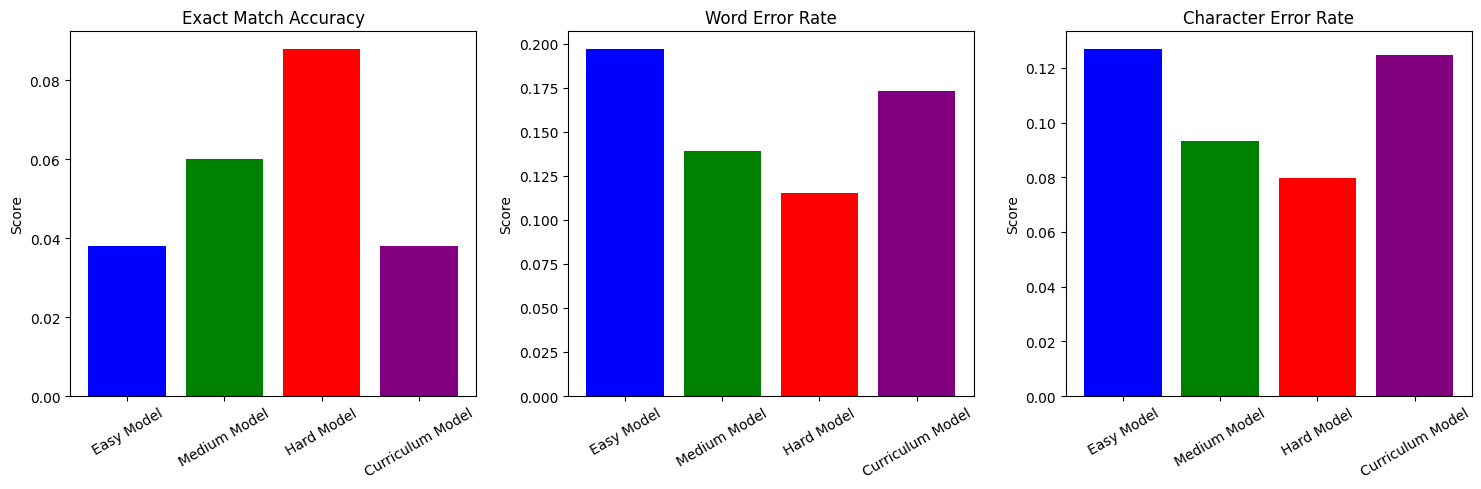


==== Evaluation Completed Successfully! ====


In [39]:
import torch
import evaluate
import gc
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader, default_collate
from torch.nn.utils.rnn import pad_sequence
from tqdm.notebook import tqdm
from transformers import T5ForConditionalGeneration

# Model checkpoints
checkpoint_paths = {
    "Easy Model": "/kaggle/working/kaggle_fine_tuned_t5_easy",
    "Medium Model": "/kaggle/working/kaggle_fine_tuned_t5_medium",
    "Hard Model": "/kaggle/working/kaggle_fine_tuned_t5_hard",
    "Curriculum Model": "./phase_3_hard_checkpoint"  # Last trained curriculum checkpoint
}

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Efficient evaluation function with progress bar
def evaluate_spelling_correction(model, tokenizer, test_dataset, num_samples=500):
    """Evaluates a given model using a subset of the test dataset."""
    if len(test_dataset) > num_samples:
        indices = torch.randperm(len(test_dataset))[:num_samples]
        sample_dataset = test_dataset.select(indices)
    else:
        sample_dataset = test_dataset

    model.eval()
    predictions, references = [], []

    batch_size = 16
    dataloader = DataLoader(sample_dataset, batch_size=batch_size, collate_fn=default_collate)

    with torch.no_grad():
        for batch in tqdm(dataloader, total=len(dataloader), desc="Evaluating", unit="batch"):
            label_tensors = [torch.tensor([id for id in l if id != -100]) for l in batch['labels']]
            label_ids = pad_sequence(label_tensors, batch_first=True, padding_value=tokenizer.pad_token_id).to(device)
            input_ids = torch.stack([ids for ids in batch['input_ids']]).to(device)
            attention_mask = torch.stack([mask for mask in batch['attention_mask']]).to(device)

            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=MAX_TARGET_LENGTH,
                num_beams=2
            )

            for pred, ref in zip(outputs, label_ids):
                predictions.append(tokenizer.decode(pred, skip_special_tokens=True))
                references.append(tokenizer.decode(ref, skip_special_tokens=True))

            del outputs, batch
            torch.cuda.empty_cache()

    # Compute metrics
    wer_metric, cer_metric = evaluate.load("wer"), evaluate.load("cer")
    wer = wer_metric.compute(predictions=predictions, references=references)
    cer = cer_metric.compute(predictions=predictions, references=references)
    exact_match = sum(p == r for p, r in zip(predictions, references)) / len(predictions)

    return {"exact_match_accuracy": exact_match, "word_error_rate": wer, "character_error_rate": cer}

# Run evaluations for all models
evaluation_results = {}
for model_name, path in checkpoint_paths.items():
    print(f"\n==== Evaluating {model_name} ====\n")

    model = T5ForConditionalGeneration.from_pretrained(path).to(device)
    eval_results = evaluate_spelling_correction(model, tokenizer, tokenized_test, num_samples=500)

    evaluation_results[model_name] = eval_results
    print(f"Results for {model_name}: {eval_results}")

    del model
    torch.cuda.empty_cache()
    gc.collect()

# Plot results
metrics = ["exact_match_accuracy", "word_error_rate", "character_error_rate"]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, metric in enumerate(metrics):
    values = [evaluation_results[model][metric] for model in checkpoint_paths]
    axes[i].bar(checkpoint_paths.keys(), values, color=["blue", "green", "red", "purple"])
    axes[i].set_title(metric.replace("_", " ").title())
    axes[i].set_ylabel("Score")
    axes[i].set_xticklabels(checkpoint_paths.keys(), rotation=30)

plt.tight_layout()
plt.show()

print("\n==== Evaluation Completed Successfully! ====")


## NOTE: The below code are WORKING code. Don't ignore / delete.

In [ ]:
# from torch.utils.data.dataloader import default_collate
# from torch.nn.utils.rnn import pad_sequence

# from tqdm.notebook import tqdm  # Import tqdm for progress bar

# # Efficient evaluation function with a progress bar
# def evaluate_spelling_correction(model, tokenizer, test_dataset, num_samples=500):
#     # Sample a smaller subset for evaluation
#     if len(test_dataset) > num_samples:
#         indices = torch.randperm(len(test_dataset))[:num_samples]
#         sample_dataset = test_dataset.select(indices)
#     else:
#         sample_dataset = test_dataset

#     model.eval()
#     prediction = []
#     references = []

#     batch_size = 16
#     dataloader = DataLoader(sample_dataset, batch_size=batch_size, collate_fn=default_collate)
    
#     # Get device
#     device = model.device

#     with torch.no_grad():
#         for batch in tqdm(dataloader, total=len(dataloader), desc="Evaluating", unit="batch"):
#             label_tensors = [torch.tensor([id for id in l if id != -100]) for l in batch['labels']]
#             label_ids = pad_sequence(label_tensors, batch_first=True, padding_value=tokenizer.pad_token_id).to(device)
#             input_ids=torch.stack([ids for ids in batch['input_ids']]).to(device)
#             attention_mask=torch.stack([mask for mask in batch['attention_mask']]).to(device)

#             outputs = model.generate(
#                 input_ids=input_ids,
#                 attention_mask=attention_mask,
#                 max_length=MAX_TARGET_LENGTH,
#                 num_beams=2
#             )

#             for pref, ref in zip(outputs, label_ids):
#                 pred_text = tokenizer.decode(pref, skip_special_tokens=True)
#                 ref_text = tokenizer.decode(ref, skip_special_tokens=True)
#                 prediction.append(pred_text)
#                 references.append(ref_text)

#             del outputs, batch
#             torch.cuda.empty_cache()

#     print("------------------------------------------")
#     print("Sample Predictions:", prediction[:5])
#     print("Sample References:", references[:5])
#     print("------------------------------------------")

#     wer_metric = evaluate.load("wer")
#     cer_metric = evaluate.load("cer")

#     wer = wer_metric.compute(predictions=prediction, references=references)
#     cer = cer_metric.compute(predictions=prediction, references=references)

#     exact_match = sum(pred == ref for pred, ref in zip(prediction, references)) / len(prediction)

#     return {
#         "exact_match_accuracy": exact_match,
#         "word_error_rate": wer,
#         "character_error_rate": cer
#     }

In [ ]:
# print("Evaluating the model...")
# torch.cuda.empty_cache()

# eval_results = evaluate_spelling_correction(
#     model=model,
#     tokenizer=tokenizer,
#     test_dataset=tokenized_test,
#     num_samples=500
# )

# print("Evaluation results:")
# for metric, value in eval_results.items():
#     print(f"{metric}: {value}")

# # Free all resources at the end
# del model, tokenized_easy, tokenized_medium, tokenized_hard, tokenized_test
# torch.cuda.empty_cache()
# gc.collect()

# print("Evaluation completed successfully!")

This concludes the evaluation part of this notebook. Thanks for reading / using :)

## Downloading Checkpoints

In [15]:
!cd /kaggle/working

In [18]:
!zip kaggle_fine_tuned_t5_easy.zip /kaggle/working/kaggle_fine_tuned_t5_easy

  adding: kaggle/working/kaggle_fine_tuned_t5_easy/ (stored 0%)


In [23]:
!ls

kaggle_fine_tuned_t5_easy    phase_1_easy_checkpoint	results
kaggle_fine_tuned_t5_hard    phase_2_medium_checkpoint	state.db
kaggle_fine_tuned_t5_medium  phase_3_hard_checkpoint


In [31]:
import shutil
shutil.make_archive('phase_3_hard_checkpoint', 'zip', '/kaggle/working/phase_3_hard_checkpoint')

'/kaggle/working/phase_3_hard_checkpoint.zip'

In [32]:
from IPython.display import FileLink
FileLink('phase_3_hard_checkpoint.zip')

/kaggle/working/phase_3_hard_checkpoint.zip